In this notebook we explore more about eye tracking data analysis

In [42]:
# Derived from:
#     https://www.axonlab.org/hcph-sops/data-management/eyetrack-qc
# Load the autoreload extension
%load_ext autoreload
# Set autoreload to update the modules every time before executing a new line of code
%autoreload 2

%matplotlib inline
from pathlib import Path
import json
import ppjson
from importlib import reload  # For debugging purposes

import numpy as np
import pandas as pd

import eyetrackingrun as et

from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from write_bids_yiwei import EyeTrackingRun, write_bids, write_bids_from_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
BIDS_PATH = Path("D:\\Eye_Dataset\\Sub004\\230928_anatomical_MREYE_study\\ET_EDF")
FILE_NAME ='HV1'
session = "004" #can be a string to be defined when required
tsv_name = f"{FILE_NAME}.tsv.gz"
gif_name = f'{FILE_NAME}.gif'


In [50]:
# Read in tsv.gz file
# Naming convension can be modified later
# recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "dwi" / f"sub-001_ses-{session}_acq-highres_dir-RL_recording-eyetrack_physio.tsv.gz"
recording_file = BIDS_PATH / tsv_name
print(f'recording_file: {recording_file}')
recording = pd.read_csv(
    recording_file,
#     sep=r"\s+",
    sep="\t",
    na_values="n/a",
)
recording.head()

metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())
print(f'meta_data: {metadata}')

recording_file: D:\Eye_Dataset\Sub004\230928_anatomical_MREYE_study\ET_EDF\HV1.tsv.gz
meta_data: {'AverageCalibrationError': [0.83], 'CalibrationCount': 1, 'CalibrationLog': [[8363063, '>>>>>>> CALIBRATION (HV5,P-CR) FOR RIGHT: <<<<<<<<<'], [8363063, 'Calibration points:'], [8363063, '-28.3, -31.5         0,      0'], [8363063, '-28.1, -46.6         0,  -2457'], [8363063, '-27.5, -16.8         0,   2457'], [8363063, '-53.5, -26.9     -3474,      0'], [8363063, '0.8, -32.3      3474,      0'], [8363063, 'eye check box: (L,R,T,B)\n\t  -59     6   -50   -14'], [8363063, 'href cal range: (L,R,T,B)\n\t-5211  5211 -3686  3686'], [8363063, 'Cal coeff:(X=a+bx+cy+dxx+eyy,Y=f+gx+goaly+ixx+jyy)\n   5.882e-05  128.85 -2.6981 -0.32252 -0.27224 \n   4.4115e-05  18.152  164.76 -0.47148  0.15712'], [8363063, 'Prenormalize: offx, offy = -28.27 -31.466'], [8363063, 'Gains: cx:109.591 lx:131.585 rx:97.338'], [8363063, 'Gains: cy:175.857 ty:168.316 by:181.496'], [8363063, 'Resolution (upd) at screen cente

# Metadata and calibration

We always run a calibration before it is started. As a result, we will typically see the metadata corresponding to calibration on this particular run.

Now, let's print out the contents of the BIDS' sidecar JSON corresponding to the DWI in this session.

In [51]:
recording

,Unnamed: 0,eye1_x_coordinate,eye1_y_coordinate,eye1_pupil_size,eye1_pupil_x_coordinate,eye1_pupil_y_coordinate,eye1_href_x_coordinate,eye1_href_y_coordinate,fast_raw_x_velocity,screen_ppdeg_x_coordinate,screen_ppdeg_y_coordinate,timestamp,eye1_fixation,eye1_saccade,eye1_blink
0,0,454.200012,412.000000,2514.0,-2981.0,-3153.0,535.0,1105.0,4.590794e-41,26.6,26.6,8431141,0,0,0
1,1,454.299988,410.299988,2513.0,-2981.0,-3165.0,535.0,1089.0,4.590794e-41,26.6,26.6,8431142,0,0,0
2,2,454.200012,406.100006,2519.0,-2983.0,-3196.0,535.0,1047.0,4.590794e-41,26.6,26.6,8431143,0,0,0
3,3,454.200012,401.899994,2526.0,-2985.0,-3227.0,535.0,1006.0,4.590794e-41,26.6,26.6,8431144,0,0,0
4,4,454.200012,401.899994,2526.0,-2985.0,-3227.0,535.0,1006.0,4.590794e-41,26.6,26.6,8431145,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724258,724258,475.200012,284.500000,2538.0,-2806.0,-4117.0,742.0,-152.0,-4.115000e+03,26.5,26.5,9155399,0,1,0
724259,724259,477.600006,283.200012,2520.0,-2782.0,-4128.0,766.0,-165.0,-4.115000e+03,26.6,26.5,9155400,0,1,0
724260,724260,479.299988,281.500000,2509.0,-2765.0,-4142.0,783.0,-181.0,-4.115000e+03,26.6,26.5,9155401,0,1,0
724261,724261,477.399994,281.200012,2507.0,-2784.0,-4143.0,764.0,-184.0,-4.115000e+03,26.6,26.5,9155402,0,1,0


In [52]:
t_axis = (
    recording.timestamp.values - recording.timestamp[0]
) / metadata["SamplingFrequency"]


In [53]:
print(metadata["Columns"])
recording = recording.rename(
        columns={
            f"eye1_pupil_size": f"pupil_size",
            f"eye1_fixation": f"fixation",
            f"eye1_saccade": f"saccade",
            f"eye1_blink": f"blink",
            f"eye1_x_coordinate": f"x_coordinate", 
            f"eye1_y_coordinate": f"y_coordinate"         
        }
    )

metadata["Columns"] = recording.columns.tolist()
print(metadata["Columns"])

['eye1_x_coordinate', 'eye1_y_coordinate', 'eye1_pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'eye1_fixation', 'eye1_saccade', 'eye1_blink']
['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'fixation', 'saccade', 'blink']


In [55]:
recording

,Unnamed: 0,x_coordinate,y_coordinate,pupil_size,eye1_pupil_x_coordinate,eye1_pupil_y_coordinate,eye1_href_x_coordinate,eye1_href_y_coordinate,fast_raw_x_velocity,screen_ppdeg_x_coordinate,screen_ppdeg_y_coordinate,timestamp,fixation,saccade,blink
0,0,454.200012,412.000000,2514.0,-2981.0,-3153.0,535.0,1105.0,4.590794e-41,26.6,26.6,8431141,0,0,0
1,1,454.299988,410.299988,2513.0,-2981.0,-3165.0,535.0,1089.0,4.590794e-41,26.6,26.6,8431142,0,0,0
2,2,454.200012,406.100006,2519.0,-2983.0,-3196.0,535.0,1047.0,4.590794e-41,26.6,26.6,8431143,0,0,0
3,3,454.200012,401.899994,2526.0,-2985.0,-3227.0,535.0,1006.0,4.590794e-41,26.6,26.6,8431144,0,0,0
4,4,454.200012,401.899994,2526.0,-2985.0,-3227.0,535.0,1006.0,4.590794e-41,26.6,26.6,8431145,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724258,724258,475.200012,284.500000,2538.0,-2806.0,-4117.0,742.0,-152.0,-4.115000e+03,26.5,26.5,9155399,0,1,0
724259,724259,477.600006,283.200012,2520.0,-2782.0,-4128.0,766.0,-165.0,-4.115000e+03,26.6,26.5,9155400,0,1,0
724260,724260,479.299988,281.500000,2509.0,-2765.0,-4142.0,783.0,-181.0,-4.115000e+03,26.6,26.5,9155401,0,1,0
724261,724261,477.399994,281.200012,2507.0,-2784.0,-4143.0,764.0,-184.0,-4.115000e+03,26.6,26.5,9155402,0,1,0


Check the pupil area

(100.0, 150.0)

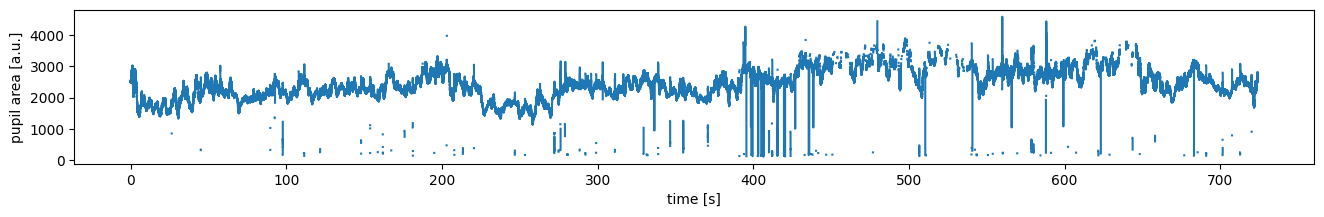

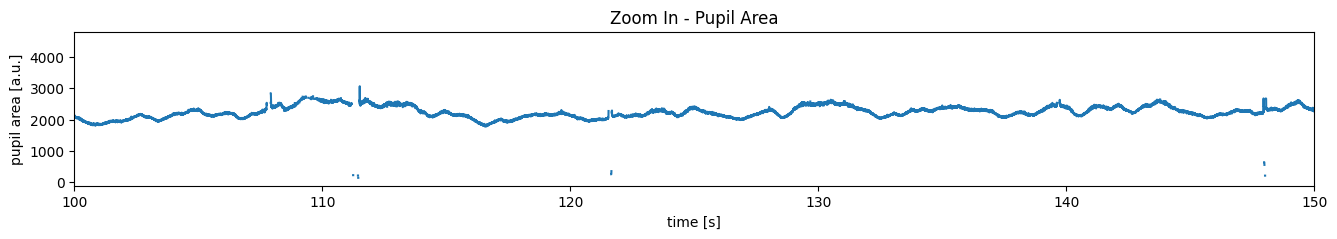

In [56]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["pupil_size"].values,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]");

fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["pupil_size"].values,
)
plt.title("Zoom In - Pupil Area")
plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]")
# JB1 (100, 150)
plt.xlim((100, 150))

Check the eye events:

 - Blink
    
- Saccade
    
- Fixation

Check blinking

(100.0, 150.0)

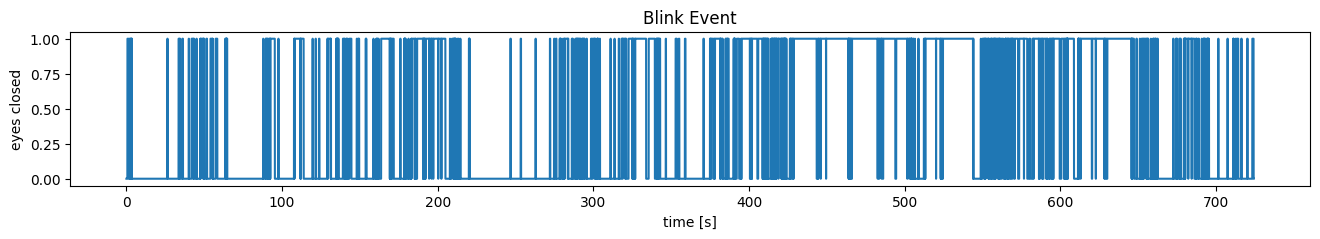

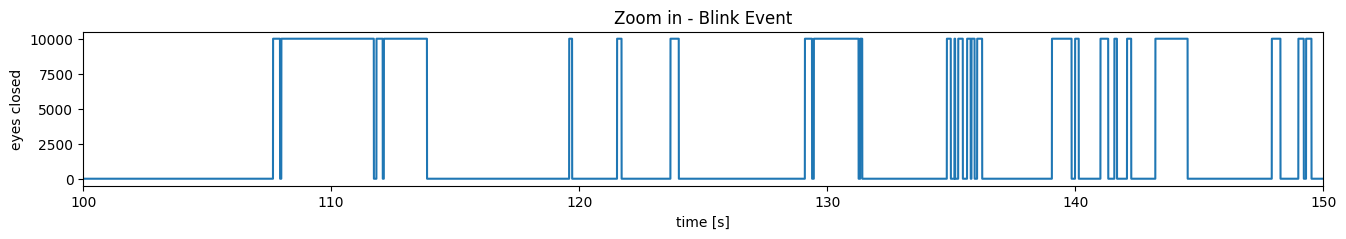

In [57]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["blink"].values,
)
plt.title("Blink Event")
plt.xlabel("time [s]")
plt.ylabel("eyes closed");

fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["blink"].values * 10000,
)
plt.xlabel("time [s]")
plt.ylabel("eyes closed")
plt.title("Zoom in - Blink Event")
plt.xlim((100, 150))

At this time, since blinking is detected, we cannot get clear pupil area ?


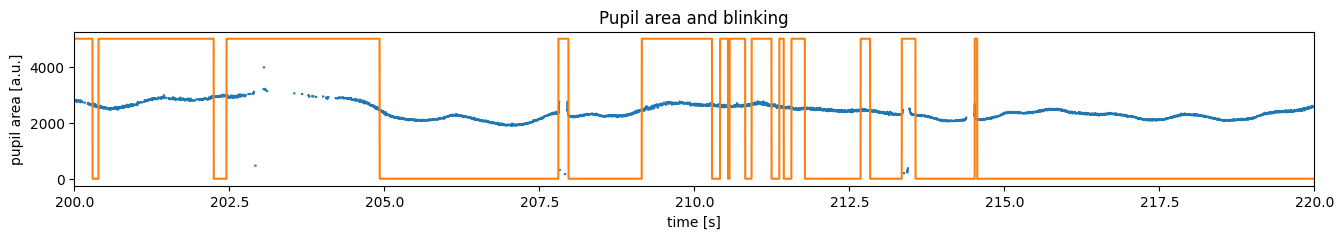

In [19]:
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis,
    recording["pupil_size"].values,
)

plt.plot(
    t_axis,
    recording["blink"].values * 5000,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]")
plt.xlim((200, 220))
plt.title('Pupil area and blinking')

print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

Check saccading

(100.0, 150.0)

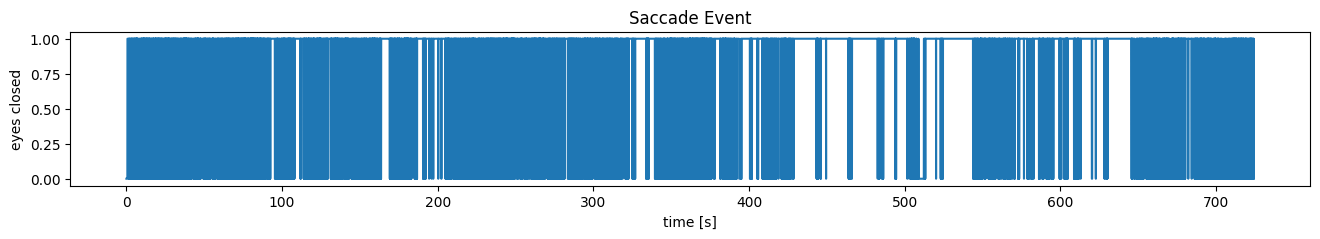

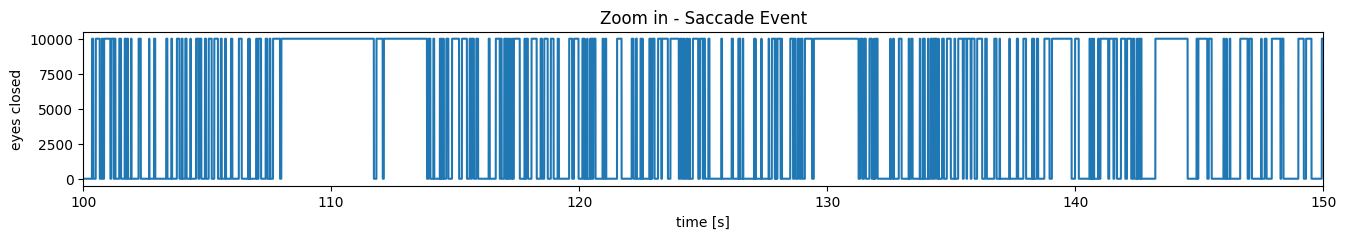

In [58]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["saccade"].values,
)
plt.title("Saccade Event")
plt.xlabel("time [s]")
plt.ylabel("eyes closed");

fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["saccade"].values * 10000,
)
plt.xlabel("time [s]")
plt.ylabel("eyes closed")
plt.title("Zoom in - Saccade Event")
plt.xlim((100, 150))

At this time, since blinking is detected, we cannot get clear pupil area ?


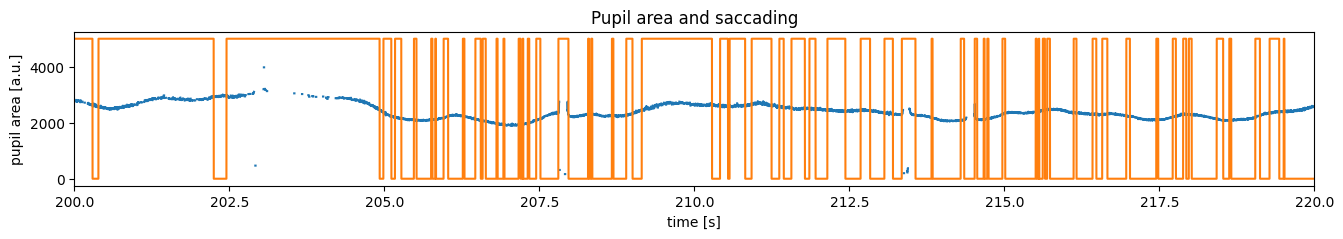

In [59]:
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis,
    recording["pupil_size"].values,
)

plt.plot(
    t_axis,
    recording["saccade"].values * 5000,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]")
plt.xlim((200, 220))
plt.title('Pupil area and saccading')
print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

(200.0, 220.0)

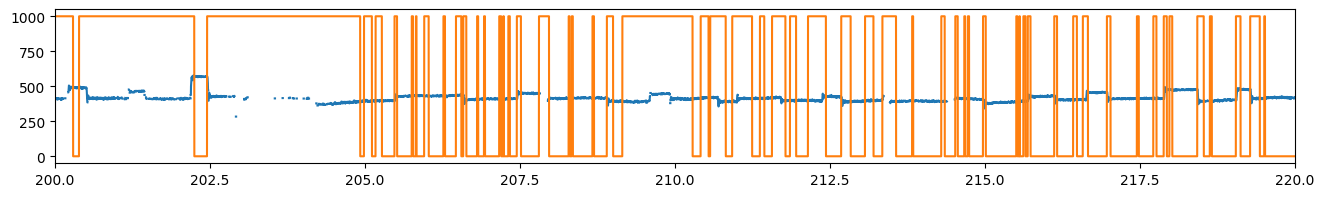

In [60]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["x_coordinate"].values,
)

plt.plot(
    t_axis,
    recording["saccade"].values * 1000,
)
plt.xlim((200, 220))

Check fixation

(205.0, 210.0)

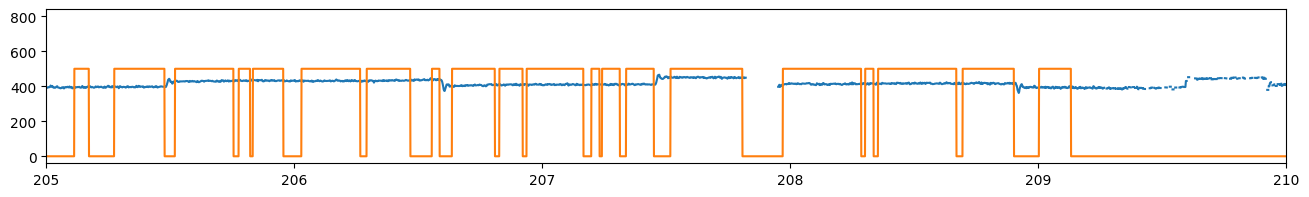

In [63]:
# Fixation
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["x_coordinate"].values,
)

plt.plot(
    t_axis,
    recording["fixation"].values * 500,
)
plt.xlim((205, 210))

The analysis did not reveal a strong correlation between pupil size or x-coordinate and saccade or fixation events.
